In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 读取CSV文件并选择需要的列
df1 = pd.read_csv('g15_hepad_s15_4s_20170321_20170321.csv')[['time_tag', 'S1_COUNT_RATE']]
df2 = pd.read_csv('g15_hepad_s15_4s_20170322_20170322.csv')[['time_tag', 'S1_COUNT_RATE']]

# 获取训练数据个数
n_train = df1.shape[0]

# 合并两个数据框
df = pd.concat([df1, df2])


# 提取'time_tag'和'S1_COUNT_RATE'列
time_tag = df['time_tag']
S1 = df['S1_COUNT_RATE']

In [3]:
# 创建一个MinMaxScaler对象
scaler = MinMaxScaler()

# 使用MinMaxScaler进行归一化处理
S1 = scaler.fit_transform(df[['S1_COUNT_RATE']])

# 将S1转换为Pandas Series对象
S1 = pd.Series(S1.flatten())

In [4]:
# plt.scatter(time_tag, S1)
# plt.show()

In [5]:
t = len(time_tag)
tau = 3
features = torch.zeros((t - tau, tau))
for i in range(tau):
    features[:, i] = torch.from_numpy(S1.values[i: t - tau + i])
labels = torch.from_numpy(S1.values[tau:].reshape((-1, 1)))

batch_size = 16
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [6]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(3, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [7]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            X = X.float()  # 转换为Float类型
            y = y.float()  # 转换为Float类型
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.000286
epoch 2, loss: 0.000328
epoch 3, loss: 0.000291
epoch 4, loss: 0.000300
epoch 5, loss: 0.000306


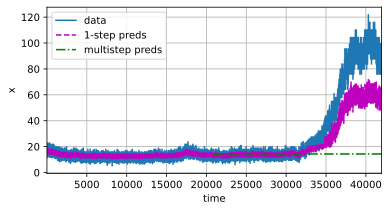

In [8]:
onestep_preds = net(features)
multistep_preds = np.zeros(t)
multistep_preds[: n_train + tau] = S1.values[: n_train + tau]
multistep_preds = torch.from_numpy(multistep_preds).float()

for i in range(n_train + tau, t):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

# 使用inverse_transform进行归一化的逆处理
one_preds_inverse = scaler.inverse_transform(onestep_preds.detach().numpy().reshape(-1, 1))
multi_preds_inverse = scaler.inverse_transform(multistep_preds.detach().numpy().reshape(-1, 1))

# 确保 S1 是一个 numpy 数组
S1_numpy = S1.values if isinstance(S1, pd.Series) else S1

# 对 S1 进行归一化的逆处理
S1_inverse = scaler.inverse_transform(S1_numpy.reshape(-1, 1))

# 将 S1_inverse 转换为 Pandas Series 对象
S1 = pd.Series(S1_inverse.flatten())

# 将preds_inverse转换为Pandas Series对象
onestep_preds = pd.Series(one_preds_inverse.flatten())
multistep_preds = pd.Series(multi_preds_inverse.flatten())

d2l.plot([time_tag, time_tag[tau:], time_tag[n_train + tau:]],
         [S1.values, onestep_preds.values,
          multistep_preds[n_train + tau:].values], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, len(S1)], figsize=(6, 3))